In [105]:
import model
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt




## Prepare data

In [106]:
### Prepare data

cordata = pd.read_csv("cordata.csv")
macro = pd.read_csv("disaggregated.csv")
dummy = pd.read_csv("dummy.csv")

macro = macro.rename(columns = {"Unnamed: 3": "Date"})
features = pd.merge(macro, dummy, on="Date")

target = cordata[["Date", "BIR", "BOC", "Other Offices"]]
features = features[["Date", "Inflation", "Imports", "Exports", "USDPHP", "NominalGDP_disagg", "Pop_disagg", 
                     "COVID-19", "TRAIN","CREATE","FIST","BIR_COMM"]]
# features = features[["Date", "Inflation", "Imports", "Exports", "USDPHP", "NominalGDP_disagg", "Pop_disagg", 
#                      "COVID-19"]]

# Convert Date to datetime
target["Date"] = pd.to_datetime(target["Date"])
features["Date"] = pd.to_datetime(features["Date"])

# Filter both to start from 1992-01-01
target = target[target["Date"] >= "1992-01-01"]
features = features[features["Date"] >= "1992-01-01"]

target = target.set_index("Date")
features = features.set_index("Date")

# Replace NaN values with 0
features = features.fillna(0)

C:\Users\Jojie\AppData\Local\Temp\ipykernel_74404\2035578202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["Date"] = pd.to_datetime(target["Date"])


In [107]:
### Add lag features
# Create lag-1 features from target variables
lag_features = target.shift(1)

# Rename lag columns
lag_features.columns = [f"{col}_lag1" for col in lag_features.columns]

# Merge lag features with features
features = pd.concat([features, lag_features], axis=1)

# Drop rows with NaN (first row will have NaN for lag features)
features = features.dropna()
target = target.loc[features.index]

print(f"Features shape after adding lag-1: {features.shape}")
print(f"Target shape after alignment: {target.shape}")
print(f"New features:\n{features.columns.tolist()}")

Features shape after adding lag-1: (393, 14)
Target shape after alignment: (393, 3)
New features:
['Inflation', 'Imports', 'Exports', 'USDPHP', 'NominalGDP_disagg', 'Pop_disagg', 'COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM', 'BIR_lag1', 'BOC_lag1', 'Other Offices_lag1']


In [108]:
### Data split
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split: 70% train, 30% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=(val_size + test_size), random_state=42, shuffle=False)

# Second split: split the temp set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print("Data Split Summary:")
print(f"Train set: {X_train.shape[0]} samples ({train_size*100:.0f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({val_size*100:.0f}%)")
print(f"Test set: {X_test.shape[0]} samples ({test_size*100:.0f}%)")
print(f"\nTrain date range: {y_train.index[0].date()} to {y_train.index[-1].date()}")
print(f"Validation date range: {y_val.index[0].date()} to {y_val.index[-1].date()}")
print(f"Test date range: {y_test.index[0].date()} to {y_test.index[-1].date()}")

Data Split Summary:
Train set: 275 samples (70%)
Validation set: 59 samples (15%)
Test set: 59 samples (15%)

Train date range: 1992-02-01 to 2015-02-01
Validation date range: 2015-03-01 to 2020-01-01
Test date range: 2020-02-01 to 2024-12-01


In [109]:
### Create sequences
def create_sequences(data, seq_length):
    """
    Create sequences of data for time series modeling.
    
    Args:
        data: pandas DataFrame or numpy array
        seq_length: length of sequence (e.g., 7, 14, 30)
    
    Returns:
        X_seq: sequences of shape (n_samples, seq_length, n_features)
        y_seq: target values corresponding to sequences
        indices: original indices for tracking dates
    """
    X_seq = []
    y_seq = []
    indices = []
    
    data_array = data.values if isinstance(data, pd.DataFrame) else data
    
    for i in range(len(data_array) - seq_length):
        X_seq.append(data_array[i:i+seq_length])
        y_seq.append(data_array[i+seq_length])
        indices.append(i+seq_length)
    
    return np.array(X_seq), np.array(y_seq), indices

# Define sequence length (how many days to look back)
sequence_length = 12  # Use 7 days to predict the next day (change as needed)

# Create sequences for features only
X_seq, _, X_indices = create_sequences(features, sequence_length)

# For targets, we just need the value at each index (not sequences)
# but align with the same indices
y_data = target.values
y_seq = y_data[X_indices]
y_indices = target.index[X_indices]

# Create new dataframes
features_seq = pd.DataFrame(index=y_indices)
target_seq = pd.DataFrame(y_seq, columns=target.columns, index=y_indices)

print(f"Sequences created with length: {sequence_length}")
print(f"X_seq shape: {X_seq.shape} (n_samples, seq_length, n_features)")
print(f"y_seq shape: {y_seq.shape}")
print(f"New date range: {y_indices[0].date()} to {y_indices[-1].date()}")

Sequences created with length: 12
X_seq shape: (381, 12, 14) (n_samples, seq_length, n_features)
y_seq shape: (381, 3)
New date range: 1993-02-01 to 2024-12-01


In [110]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((275, 14), (59, 14), (275, 3), (59, 3))

#Apply transformations

In [111]:
# Apply MinMaxScaler to X_train and y_train
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform X_train
X_train_scaled = scaler_X.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Fit and transform y_train
y_train_scaled = scaler_y.fit_transform(y_train)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)

# Transform X_test and y_test using the fitted scalers
X_val_scaled = scaler_X.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

y_val_scaled = scaler_y.transform(y_val)
y_val_scaled = pd.DataFrame(y_val_scaled, columns=y_val.columns, index=y_val.index)

# Transform X_test and y_test using the fitted scalers
X_test_scaled = scaler_X.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y_test_scaled = scaler_y.transform(y_test)
y_test_scaled = pd.DataFrame(y_test_scaled, columns=y_test.columns, index=y_test.index)


#Load to dataloader

In [112]:
# Convert scaled data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled.values)
y_train_tensor = torch.FloatTensor(y_train_scaled.values)

X_val_tensor = torch.FloatTensor(X_val_scaled.values)
y_val_tensor = torch.FloatTensor(y_val_scaled.values)

X_test_tensor = torch.FloatTensor(X_test_scaled.values)
y_test_tensor = torch.FloatTensor(y_test_scaled.values)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#Train Model

In [114]:
### Train model

# Check for NaN values in data
print(f"NaN in X_train_tensor: {torch.isnan(X_train_tensor).any()}")
print(f"NaN in y_train_tensor: {torch.isnan(y_train_tensor).any()}")
print(f"X_train_tensor range: [{X_train_tensor.min():.4f}, {X_train_tensor.max():.4f}]")
print(f"y_train_tensor range: [{y_train_tensor.min():.4f}, {y_train_tensor.max():.4f}]")

# Determine device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model parameters
input_size = X_train_tensor.shape[1]  # Number of features
num_channels = [32, 32, 32, 32, 32, 32]
output_size = y_train_tensor.shape[1]  # Number of target variables
kernel_size = 3
dropout = 0.4

# Initialize model
tcn_model = model.TCNRegressor(
    input_size=input_size,
    num_channels=num_channels,
    output_size=output_size,
    kernel_size=kernel_size,
    dropout=dropout
).to(device)

# Loss function and optimizer
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.0005)  

# Training loop
epochs = 50
train_losses = []
val_losses = []
max_grad_norm = 1.0  # Gradient clipping threshold

print("Starting training...")
for epoch in range(epochs):
    # Training phase
    tcn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Reshape for TCN (batch, features, sequence_length)
        # Since we have single timestep data, add sequence dimension
        X_batch = X_batch.unsqueeze(-1)  # (batch, features, 1)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = tcn_model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(tcn_model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    tcn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            X_batch = X_batch.unsqueeze(-1)
            
            predictions = tcn_model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

print("Training completed!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Val Loss: {val_losses[-1]:.6f}")

NaN in X_train_tensor: False
NaN in y_train_tensor: False
X_train_tensor range: [0.0000, 1.0000]
y_train_tensor range: [0.0000, 1.0000]
Using device: cpu
Starting training...


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 10/50 - Train Loss: 0.016531, Val Loss: 0.119746
Epoch 20/50 - Train Loss: 0.007949, Val Loss: 0.044079
Epoch 30/50 - Train Loss: 0.007067, Val Loss: 0.043203
Epoch 40/50 - Train Loss: 0.005551, Val Loss: 0.039745
Epoch 50/50 - Train Loss: 0.005227, Val Loss: 0.039321
Training completed!
Final Train Loss: 0.005227
Final Val Loss: 0.039321


In [115]:
# Make predictions on test set
tcn_model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.unsqueeze(-1)
        
        predictions = tcn_model(X_batch)
        all_predictions.append(predictions.cpu().numpy())
        all_actuals.append(y_batch.cpu().numpy())

# Concatenate all predictions and actuals
predictions_scaled = np.vstack(all_predictions)
actuals_scaled = np.vstack(all_actuals)

# Inverse transform to get original scale
predictions_original = scaler_y.inverse_transform(predictions_scaled)
actuals_original = scaler_y.inverse_transform(actuals_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))
mae = mean_absolute_error(actuals_original, predictions_original)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actuals_original - predictions_original) / actuals_original)) * 100

print("=== Model Performance Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

# Get predictions for all dates up to 2024
print("\n=== Predictions up to 2024 ===")
print(f"Test set date range: {y_test.index[0].date()} to {y_test.index[-1].date()}")

# Create results dataframe
results_df = pd.DataFrame(index=y_test.index)
for i, col in enumerate(y_test.columns):
    results_df[f"{col}_Actual"] = actuals_original[:, i]
    results_df[f"{col}_Predicted"] = predictions_original[:, i]

print(f"\nResults shape: {results_df.shape}")
print("\nLast 10 rows of predictions:")
print(results_df.tail(10))

=== Model Performance Metrics ===
RMSE: 40883.4957
MAE: 22293.7812
MAPE: 24.2788%

=== Predictions up to 2024 ===
Test set date range: 2020-02-01 to 2024-12-01

Results shape: (59, 6)

Last 10 rows of predictions:
              BIR_Actual  BIR_Predicted    BOC_Actual  BOC_Predicted  \
Date                                                                   
2024-03-01  145346.00000  159796.796875  74895.000000   46551.738281   
2024-04-01  378521.00000  173850.437500  80742.007812   50767.773438   
2024-05-01  219228.00000  193031.296875  81301.007812   55965.945312   
2024-06-01  172503.00000  180210.796875  74623.000000   52688.054688   
2024-07-01  319814.00000  168015.546875  80355.000000   48750.378906   
2024-08-01  238120.00000  190720.656250  78521.000000   55291.453125   
2024-09-01  174679.00000  186070.125000  76282.000000   54228.289062   
2024-10-01  325535.96875  172136.078125  86885.000000   49969.242188   
2024-11-01  247594.00000  187461.109375  72441.000000   54478.9101

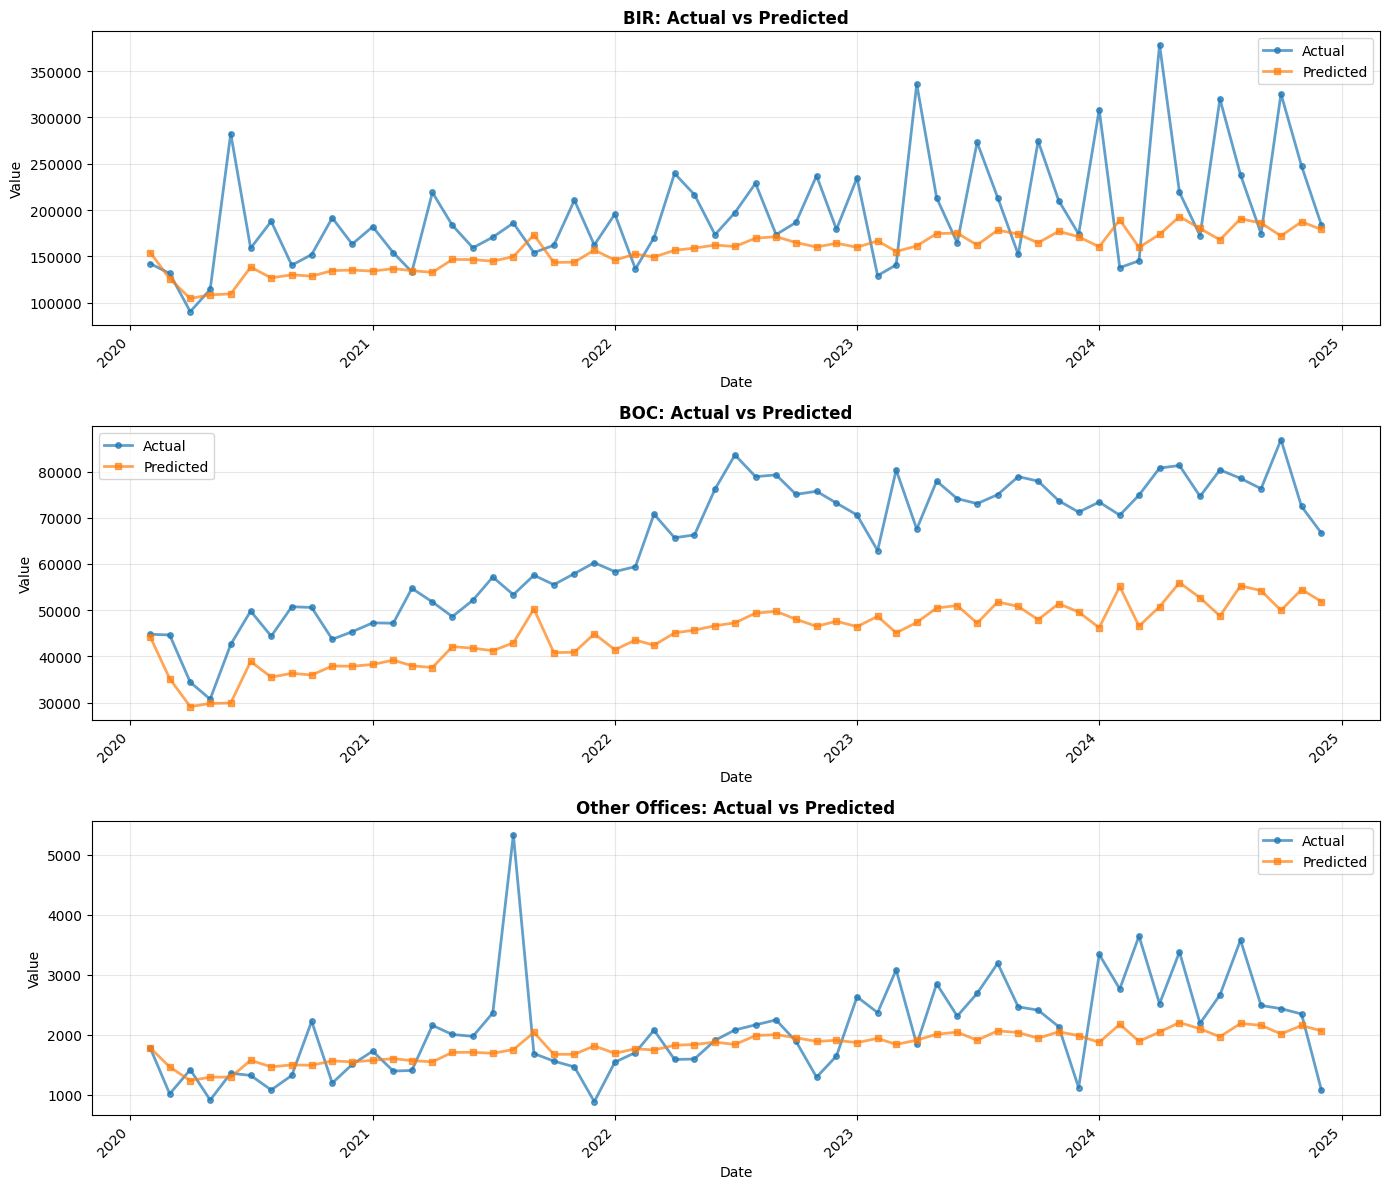

Graph saved as 'tcn_predictions_comparison.png'

=== Per-Variable Performance Metrics ===

BIR:
  RMSE: 67550.9654
  MAE: 47123.2461
  MAPE: 20.5757%

BOC:
  RMSE: 21228.9923
  MAE: 19247.1094
  MAPE: 28.3428%

Other Offices:
  RMSE: 759.9884
  MAE: 510.9881
  MAPE: 23.9181%


In [116]:
# Create comparison plots for each target variable
fig, axes = plt.subplots(len(y_test.columns), 1, figsize=(14, 4 * len(y_test.columns)))

# If only one target variable, axes is not an array
if len(y_test.columns) == 1:
    axes = [axes]

for i, col in enumerate(y_test.columns):
    ax = axes[i]
    
    # Plot actual vs predicted
    ax.plot(results_df.index, results_df[f"{col}_Actual"], 
            label='Actual', linewidth=2, marker='o', markersize=4, alpha=0.7)
    ax.plot(results_df.index, results_df[f"{col}_Predicted"], 
            label='Predicted', linewidth=2, marker='s', markersize=4, alpha=0.7)
    
    # Formatting
    ax.set_title(f'{col}: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('tcn_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graph saved as 'tcn_predictions_comparison.png'")

# Calculate per-variable metrics
print("\n=== Per-Variable Performance Metrics ===")
for i, col in enumerate(y_test.columns):
    actual = actuals_original[:, i]
    predicted = predictions_original[:, i]
    
    rmse_var = np.sqrt(mean_squared_error(actual, predicted))
    mae_var = mean_absolute_error(actual, predicted)
    mape_var = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{col}:")
    print(f"  RMSE: {rmse_var:.4f}")
    print(f"  MAE: {mae_var:.4f}")
    print(f"  MAPE: {mape_var:.4f}%")